# MEFISTO application to longitudinal microbiome data

This notebook demonstrates how longitudinal data can be analysed with MEFISTO with its interface for muon.

Please find more information about this method [on its website](https://biofam.github.io/MOFA2/MEFISTO) and [in the preprint](https://www.biorxiv.org/content/10.1101/2020.11.03.366674v1) by Britta Velten et al.

Other versions of this notebook are available: [R version here](https://raw.githack.com/bioFAM/MEFISTO_tutorials/master/microbiome_tutorial.html) and [Python version here](https://github.com/bioFAM/MEFISTO_tutorials/blob/master/MEFISTO_microbiome.ipynb).

The data for this notebook can be downloaded [from here](https://figshare.com/s/242916198fde3353f3e6). The following files are used in this tutorial:

- `microbiome_data.csv` containing the microbiome data used as input,
- `microbiome_features_metadata.csv` containing taxonomic information for the features in the model.

The original data was published by [Bokulich et al.](https://stm.sciencemag.org/content/8/343/343ra82)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.sparse import csr_matrix

import muon as mu

from muon import AnnData, MuData

In [2]:
# Set the working directory to the root of the repository
import os
os.chdir("../")

## Load data

In this notebook, we put the files into the `data/microbiome/` directory.

We first load the dataframe that contains the preprocessed microbiome data for all children (groups) as well as the time annotation (month of life) for each sample.

In [3]:
datadir = "data/microbiome/"

In [4]:
microbiome = pd.read_csv(f"{datadir}/microbiome_data.csv")
microbiome.head()

,group,month,feature,value,view,sample,delivery,diet,sex
0,C001,0,ac5402de1ddf427ab8d2b0a8a0a44f19,0.616022,microbiome,C001_0,Vaginal,bd,Female
1,C001,0,2a2947125c677c6e27898ad4e9b9dca7,NaN,microbiome,C001_0,Vaginal,bd,Female
2,C001,0,0cc2420a6a4698f8bf664d50b17d26b4,NaN,microbiome,C001_0,Vaginal,bd,Female
3,C001,0,651794369aeb3db83839b81fe49c8b4e,NaN,microbiome,C001_0,Vaginal,bd,Female
4,C001,0,e6a34eb113dba66df0b8bbec907a8f5d,-0.416379,microbiome,C001_0,Vaginal,bd,Female


From this table, we will make (1) a matrix with values and (2) a metadata table for samples.

In [5]:
adata = AnnData(X=microbiome.pivot(index="sample", columns="feature", values="value"))
adata

AnnData object with n_obs × n_vars = 1032 × 969

In [6]:
adata.obs = (adata.obs
             .join(
                 microbiome.loc[:,["sample", "group", "month", "delivery", "diet", "sex"]]
                 .drop_duplicates()
                 .set_index("sample"),
                 sort=False
             )
)

adata.obs.head()

,group,month,delivery,diet,sex
sample,,,,,
C001_0,C001,0,Vaginal,bd,Female
C001_1,C001,1,Vaginal,bd,Female
C001_10,C001,10,Vaginal,bd,Female
C001_11,C001,11,Vaginal,bd,Female
C001_12,C001,12,Vaginal,bd,Female


We will also add features metadataw:

In [7]:
feature_meta = pd.read_csv(f"{datadir}/microbiome_features_metadata.csv")
feature_meta[["kingdom", "phylum", "class", "order", "family", "genus", "species"]] = feature_meta.Taxon.str.split("; ", expand=True)

In [8]:
adata.var = (adata.var
             .join(
                 feature_meta.set_index("SampleID"),
                 sort=False
             )
)

adata.var.head()

,Taxon,Confidence,kingdom,phylum,class,order,family,genus,species
feature,,,,,,,,,
0021d135d4ac12982cc8abdf2b38e23f,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.999988,k__Bacteria,p__Bacteroidetes,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__eggerthii
009a4919860d6d1fddec5d3771d37351,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.988051,k__Bacteria,p__Firmicutes,c__Bacilli,o__Lactobacillales,f__Lactobacillaceae,None,None
00bb7a84ce1fa6f7411597672ff1b09d,k__Bacteria; p__Actinobacteria; c__Actinobacte...,0.998529,k__Bacteria,p__Actinobacteria,c__Actinobacteria,o__Actinomycetales,f__Dermacoccaceae,g__Dermacoccus,s__
010f0ac2691bc0be12d0633d4b5d2cc4,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.999978,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__Ruminococcaceae,g__Faecalibacterium,s__prausnitzii
0189d0173c07f11e7586ff20eb33f5ba,k__Bacteria; p__Firmicutes; c__Erysipelotrichi...,0.998560,k__Bacteria,p__Firmicutes,c__Erysipelotrichi,o__Erysipelotrichales,f__Erysipelotrichaceae,g__,s__


## Train a MEFISTO model

**MEFISTO** can be run on a `MuData` object with `mu.tl.mofa` by specifying which variable (*covariate*) should be treated as *time*.

- To incorporate the time information, we specify which metadata column to use as a covariate for MEFISTO — `'month'`.

- We also specify `'group'` to be used as groups.

In [9]:
mu.tl.mofa(adata, n_factors=2, 
           groups_label="group", center_groups=False,
           smooth_covariate='month',
           smooth_kwargs={"n_grid": 10, "start_opt": 50, "opt_freq": 50},
           outfile="models/mefisto_microbiome.hdf5",
           seed=2020)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='data' group='C001' with N=24 samples and D=969 features...
Loaded view='data' group='C002' with N=24 samples and D=969 features...
Loaded view='data' group='C004' with N=24 samples and D=969 features...
Loaded view='data' group='C005' with N=24 samples and D=969 features...
Loaded view='data' group='C007' with N=24 samples and D=969 features...
Loaded view='data' gr

## Visualization in the factor space

We can quickly visualize factors learned using a generic scatterplot function.

In [10]:
import scanpy as sc

In [11]:
cols4diet = {"bd": "#b2df8a", "fd": "#1f78b4"}
cols4delivery = {"Cesarean": "#e6ab02", "Vaginal": "#d95f02"}

In [12]:
adata.obs["Factor1"] = adata.obsm["X_mofa"][:,0]

... storing 'group' as categorical
... storing 'delivery' as categorical
... storing 'diet' as categorical
... storing 'sex' as categorical
... storing 'Taxon' as categorical
... storing 'kingdom' as categorical
... storing 'phylum' as categorical
... storing 'class' as categorical
... storing 'order' as categorical
... storing 'family' as categorical
... storing 'genus' as categorical
... storing 'species' as categorical


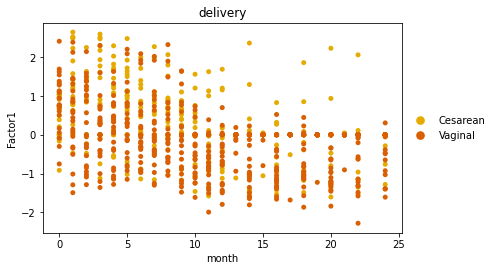

In [13]:
sc.pl.scatter(adata, x="month", y="Factor1", color="delivery", 
              palette=sns.color_palette(cols4delivery.values()), size=100)

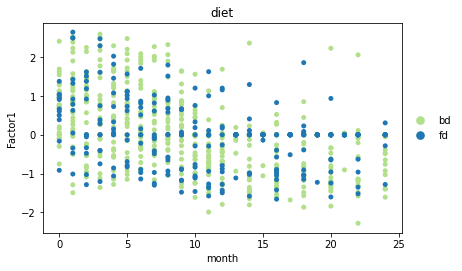

In [14]:
sc.pl.scatter(adata, x="month", y="Factor1", color="diet", 
              palette=sns.color_palette(cols4diet.values()), size=100)

## Downstream analysis

For downstream analysis we can either use R (package [MOFA2](https://github.com/bioFAM/MOFA2)) or the Python package [mofax](https://github.com/gtca/mofax). Here we will proceed in Python and first load the pre-trained model generated by the above steps.

In [15]:
import mofax

In [16]:
m = mofax.mofa_model(f"models/mefisto_microbiome.hdf5")
m

MOFA+ model: mefisto microbiome
Samples (cells): 1032
Features: 969
Groups: C001 (24), C002 (24), C004 (24), C005 (24), C007 (24), C008 (24), C009 (24), C010 (24), C011 (24), C012 (24), C014 (24), C016 (24), C017 (24), C018 (24), C020 (24), C021 (24), C022 (24), C023 (24), C024 (24), C025 (24), C027 (24), C030 (24), C031 (24), C032 (24), C033 (24), C034 (24), C035 (24), C036 (24), C037 (24), C038 (24), C041 (24), C042 (24), C043 (24), C044 (24), C045 (24), C046 (24), C047 (24), C049 (24), C052 (24), C053 (24), C055 (24), C056 (24), C057 (24)
Views: data (969)
Factors: 2
Expectations: Sigma, W, Z

MEFISTO:
Covariates available: month

### Variance decomposition and factor correlation

To obtain a first overview of the factors we can take a look at the variance that a factor explains in each child.

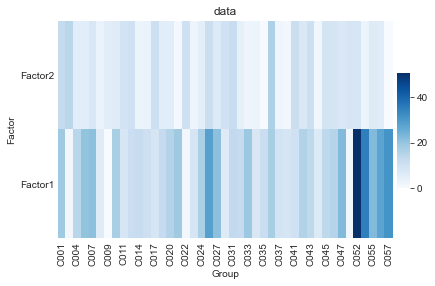

In [17]:
mofax.plot_r2(m, cmap="Blues")

### Factors versus month of life

We can also plot the inferred factors against the months of life and colour them by the metadata of the samples taking advantage of a plotting function in mofax.

Using the first two factors, we can project the samples into a 2-dimensional space.

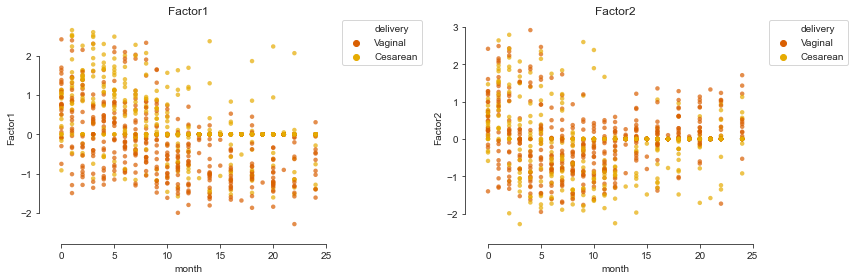

In [18]:
mofax.plot_factors(m, x="month", y=[0, 1], 
                   color="delivery", palette=cols4delivery, alpha=.7);

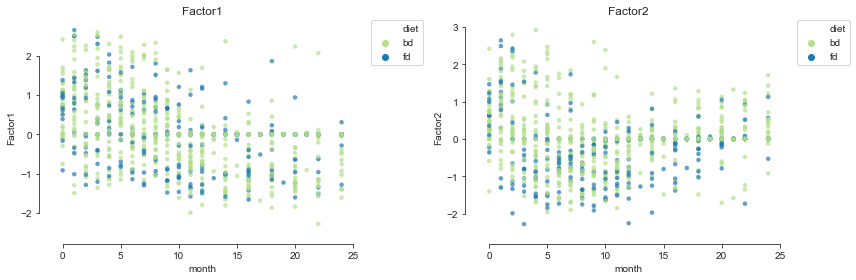

In [19]:
mofax.plot_factors(m, x="month", y=[0, 1], 
                   color="diet", palette=cols4diet, alpha=.7);

### Scatterplot

We can also look at the factor values on the sample level. Here each dot correspond to one time-point-child combination.

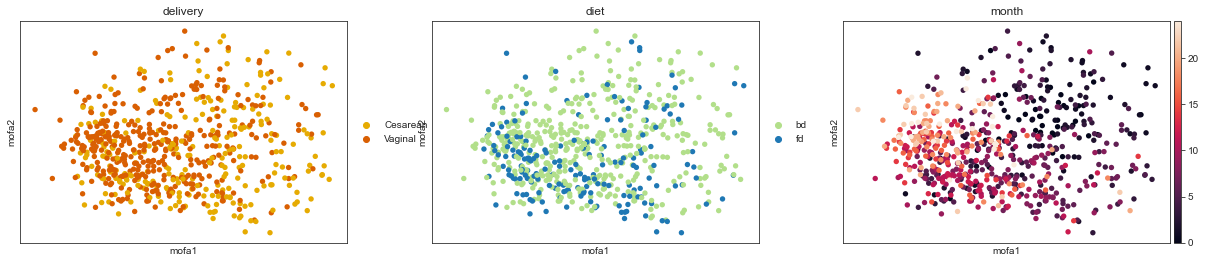

In [20]:
mu.pl.mofa(adata, color=["delivery", "diet", "month"])

## Factor weights

Next we have a look at the microbial species associated with the factors, focusing on Factor 1. For this we have a look at the weights of the factor.

### Individual species

Let’s first have a look at the top positive and top negative species on factor 1. We find top negative weights for species of the genera Bacteroides and Faecalibacterium, meaning that their abundance varies in line with the negative of Factor 1, increasing over the first year of life and with higher abundance in vaginally delivered children.

In [21]:
m.get_weights(factors="Factor1", df=True).join(m.features_metadata).sort_values("Factor1").head()

,Factor1,view,Confidence,Taxon,class,family,genus,kingdom,order,phylum,species
c4f9ef34bd2919511069f409c25de6f1,-2.010341,data,0.999160,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,c__Bacteroidia,f__Bacteroidaceae,g__Bacteroides,k__Bacteria,o__Bacteroidales,p__Bacteroidetes,s__
010f0ac2691bc0be12d0633d4b5d2cc4,-1.978174,data,0.999978,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,c__Clostridia,f__Ruminococcaceae,g__Faecalibacterium,k__Bacteria,o__Clostridiales,p__Firmicutes,s__prausnitzii
ac5402de1ddf427ab8d2b0a8a0a44f19,-1.877653,data,0.999770,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,c__Bacteroidia,f__Bacteroidaceae,g__Bacteroides,k__Bacteria,o__Bacteroidales,p__Bacteroidetes,s__
8937656c16c20701c107e715bad86732,-1.603405,data,0.758990,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,c__Clostridia,f__Lachnospiraceae,g__Roseburia,k__Bacteria,o__Clostridiales,p__Firmicutes,s__faecis
2a99ec1157a90661db7ff643b82f1914,-1.569408,data,0.997669,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,c__Bacteroidia,f__Bacteroidaceae,g__Bacteroides,k__Bacteria,o__Bacteroidales,p__Bacteroidetes,s__fragilis


We can also take a look at the data for the top features on the factor:

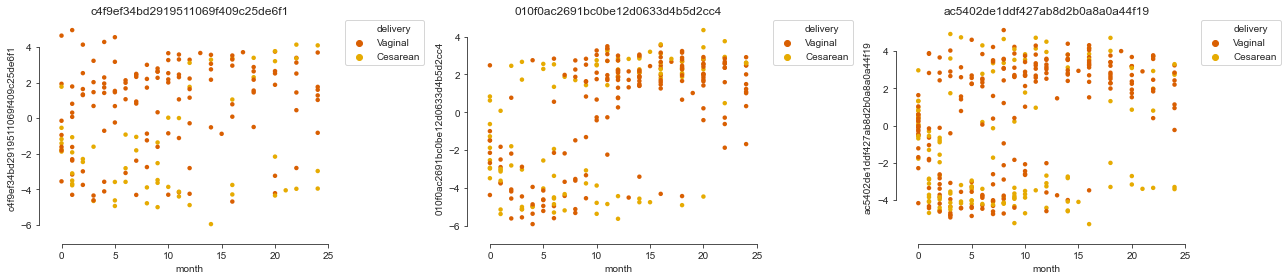

In [22]:
mofax.plot_factors(m, x="month", y=m.get_top_features(factors="Factor1", n_features=3), color="delivery", palette=cols4delivery);

### Aggregation to genus level

We now aggregate the weights on the genus level.

In [23]:
df_weights = (
    m.get_weights(df=True, factors="Factor1")
     .join(m.features_metadata)
     .query("genus != 'g__'")
)

df_weights.genus = df_weights.genus.str.replace('g__', '').str.replace('\\[', '').str.replace('\\]', '')

# summarize by mean weights across all species in the genus
# and filter to top 10 positive and negative ones
df_top = (
    df_weights
    .groupby("genus")
    .agg(mean_weight=("Factor1", "mean"),
         n_spec=("Factor1", "size"))
    .query("n_spec > 2")
    .reset_index()
    .assign(type=lambda x: np.where(x["mean_weight"] > 0, "Cesarean", "Vaginal"),
            mean_weight_abs=lambda x: np.abs(x["mean_weight"]))
    .groupby("type")
    .apply(lambda x: x.nlargest(5, "mean_weight_abs"))
    .sort_values("mean_weight", ascending=False)
    .reset_index(drop=1)
)

In [24]:
df_top

,genus,mean_weight,n_spec,type,mean_weight_abs
0,Coprobacillus,0.529192,4,Cesarean,0.529192
1,Epulopiscium,0.350463,5,Cesarean,0.350463
2,Peptoniphilus,0.342736,4,Cesarean,0.342736
3,Dysgonomonas,0.309555,4,Cesarean,0.309555
4,Enterococcus,0.281913,5,Cesarean,0.281913
5,Parabacteroides,-0.369146,9,Vaginal,0.369146
6,Roseburia,-0.381634,12,Vaginal,0.381634
7,Alistipes,-0.583242,4,Vaginal,0.583242
8,Faecalibacterium,-0.643833,9,Vaginal,0.643833
9,Bacteroides,-0.712832,25,Vaginal,0.712832


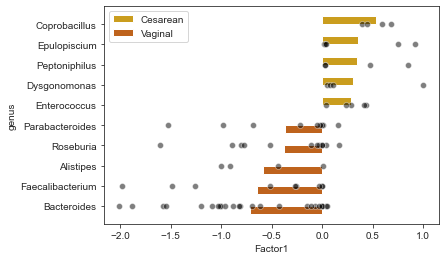

In [25]:
ax = sns.barplot(data=df_top, x="mean_weight", y="genus", hue="type", palette=cols4delivery)
sns.scatterplot(data=df_weights[df_weights.genus.isin(df_top.genus)].set_index("genus").loc[df_top.genus,:].reset_index(), 
                x="Factor1", y="genus", color="black", alpha=.5, ax=ax, zorder=10);

More details are discussed in the [original R](https://raw.githack.com/bioFAM/MEFISTO_tutorials/master/microbiome_tutorial.html) and [Python](https://github.com/bioFAM/MEFISTO_tutorials/blob/master/MEFISTO_microbiome.ipynb) notebooks.